In [1]:
require 'nn'

torch.setdefaulttensortype('torch.FloatTensor')

Integral, parent = torch.class('nn.Integral', 'nn.Module')

In [3]:
-- nn.Integral definition

cv = require 'cv'
require 'cv.imgproc'
require 'cv.highgui'

function Integral:__init(nWindows, h, w)
    parent.__init(self)
    self.nWindows, self.h, self.w = nWindows, h, w
    self.output = torch.Tensor(self.nWindows, h, w)
    self:reset()
    self:zeroGradParameters()
end

-- renew normalization coeffs
function Integral:recalculateArea()
    for i = 1,self.nWindows do
        self.areaCoeff[i] = 
            1 / ((self.xMax[i]-self.xMin[i]+1)*(self.yMax[i]-self.yMin[i]+1))
    end
end

function Integral:reset()
    -- the only parameters of the module
    self.xMin = torch.round((torch.rand(self.nWindows) - 0.5) * (2 * self.h * 0.3))
    self.yMin = torch.round((torch.rand(self.nWindows) - 0.5) * (2 * self.w * 0.3))
    self.xMax = torch.Tensor(self.nWindows)
    self.yMax = torch.Tensor(self.nWindows)
    
    for i = 1,self.nWindows do
        self.xMax[i] = torch.round(torch.uniform(self.xMin[i] + self.h * 0.05, self.xMin[i] + self.h * 0.25))
        self.yMax[i] = torch.round(torch.uniform(self.yMin[i] + self.w * 0.05, self.yMin[i] + self.w * 0.25))
    end
    
    --[[do
        -- strict initialization for debugging
        self.xMin[1] = 0
        self.xMax[1] = 0
        self.yMin[1] = 0
        self.yMax[1] = 0

        for i = 2,self.nWindows do
            self.xMin[i] = self.xMin[i-1] - 3
            self.xMax[i] = self.xMax[i-1] + 3
            self.yMin[i] = self.yMin[i-1] - 3
            self.yMax[i] = self.yMax[i-1] + 3
        end
    end]]
    
    -- area to normalize over
    self.areaCoeff = torch.Tensor(self.nWindows)
    self:recalculateArea()
    
    -- loss gradients wrt module's parameters
    self.gradXMin = torch.zeros(self.xMin:size())
    self.gradYMin = torch.zeros(self.xMin:size())
    self.gradXMax = torch.zeros(self.xMin:size())
    self.gradYMax = torch.zeros(self.xMin:size())
end

function Integral:parameters()
    local params = {self.xMin, self.xMax, self.yMin, self.yMax}
    local gradParams = {self.gradXMin, self.gradXMax, self.gradYMin, self.gradYMax}
    return params, gradParams
end

local function round_towards_zero(x)
    if x >= 0 then return math.floor(x) 
    else return math.floor(x) end
end

function Integral:updateOutput(input)
    if type(input) == 'number' then print(input) end
    if input:nDimension() ~= 2 then
        error('wrong input:nDimension()')
    end
    
--     self.output:fill(input:max())
    
    assert(input:size(1) == self.h and input:size(2) == self.w)
    
--     local xMaxInt, xMinInt = math.floor(self.xMax), math.ceil(self.xMin)
--     local xMaxDiff, xMinDiff = self.xMax-xMaxInt, self.xMin-xMinInt
--     local yMaxInt, yMinInt = math.floor(self.yMax), math.ceil(self.yMin)
--     local yMaxDiff, yMinDiff = self.yMax-yMaxInt, self.yMin-yMinInt
    
    self.integral = cv.integral{input}
    
    for planeIdx = 1,self.nWindows do
        
        -- round towards zero (?)
        local xMinCurr = round_towards_zero(self.xMin[planeIdx])
        local xMaxCurr = round_towards_zero(self.xMax[planeIdx])+1
        local yMinCurr = round_towards_zero(self.yMin[planeIdx])
        local yMaxCurr = round_towards_zero(self.yMax[planeIdx])+1
        
        -- round down (?)
--         local xMinCurr = torch.round(self.xMin[planeIdx] - 0.499)
--         local xMaxCurr = torch.round(self.xMax[planeIdx] - 0.499)+1
--         local yMinCurr = torch.round(self.yMin[planeIdx] - 0.499)
--         local yMaxCurr = torch.round(self.yMax[planeIdx] - 0.499)+1
        
        local outPlane = self.output[planeIdx]
        
        local outData = torch.data(outPlane)
        local intData = torch.data(self.integral)
        
        -- must add 1 to xMax/yMax/xMin/yMin due to OpenCV's
        -- `integral()` behavior. Namely, I(x,0) and I(0,y) are
        -- always 0 (so it's a C-style array sum).
        
        for x = 0,self.h-1 do
            for y = 0,self.w-1 do
                outData[x*self.w + y] = 0
                    + intData[math.max(0,math.min(x+xMaxCurr,self.h))*(self.w+1) 
                        + math.max(0,math.min(y+yMaxCurr,self.w))]
                    - intData[math.max(0,math.min(x+xMinCurr,self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMaxCurr,self.w))]
                    - intData[math.max(0,math.min(x+xMaxCurr,self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMinCurr,self.w))]
                    + intData[math.max(0,math.min(x+xMinCurr,self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMinCurr,self.w))]
            end
        end
        
        outPlane:mul(self.areaCoeff[planeIdx])
    end
    
    return self.output
end


function Integral:updateGradInput(input, gradOutput)
    -- never call :backward() on backpropHelper!
    self.backpropHelper = self.backpropHelper or nn.Integral(1, self.h, self.w)
    
    if self.gradInput then
        self.gradInput:resize(self.h, self.w):zero()
        
        for nWindow = 1,self.nWindows do
            self.backpropHelper.xMin[1] = -self.xMax[nWindow]
            self.backpropHelper.xMax[1] = -self.xMin[nWindow]
            self.backpropHelper.yMin[1] = -self.yMax[nWindow]
            self.backpropHelper.yMax[1] = -self.yMin[nWindow]
            self.backpropHelper:recalculateArea()
            
            self.gradInput:add(self.backpropHelper:forward(gradOutput[nWindow]):squeeze())
        end
        
        return self.gradInput
    end
end

function Integral:accGradParameters(input, gradOutput, scale)
    scale = scale or 1
    
    for planeIdx = 1,self.nWindows do
        local outputDot = torch.dot(self.output[planeIdx], gradOutput[planeIdx])
        
        -- round towards zero (?)
        -- and +1 because OpenCV's integral adds extra row and col
        local xMinCurr = round_towards_zero(self.xMin[planeIdx])+1
        local xMaxCurr = round_towards_zero(self.xMax[planeIdx])+1
        local yMinCurr = round_towards_zero(self.yMin[planeIdx])+1
        local yMaxCurr = round_towards_zero(self.yMax[planeIdx])+1
        
        -- round down (?)
--         local xMinCurr = torch.round(self.xMin[planeIdx] - 0.499)+1
--         local xMaxCurr = torch.round(self.xMax[planeIdx] - 0.499)+1
--         local yMinCurr = torch.round(self.yMin[planeIdx] - 0.499)+1
--         local yMaxCurr = torch.round(self.yMax[planeIdx] - 0.499)+1
        
        local gradOutData = torch.data(gradOutput[planeIdx])
        local intData = torch.data(self.integral)
        
        -- deltas of dOut(x,y) (sum over one window)
        local xMaxDelta, xMinDelta = 0, 0
        local yMaxDelta, yMinDelta = 0, 0
        
        for x = 1,self.h do
            for y = 1,self.w do
                xMaxDelta = xMaxDelta
                    +(intData[math.max(0,math.min(x+xMaxCurr+1,self.h))*(self.w+1) 
                        + math.max(0,math.min(y+yMaxCurr,  self.w))]
                    - intData[math.max(0,math.min(x+xMaxCurr  ,self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMaxCurr,  self.w))]
                    - intData[math.max(0,math.min(x+xMaxCurr+1,self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMinCurr-1,self.w))]
                    + intData[math.max(0,math.min(x+xMaxCurr  ,self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMinCurr-1,self.w))] )
                    * gradOutData[(x-1)*self.w + (y-1)]
                
                xMinDelta = xMinDelta
                    +(intData[math.max(0,math.min(x+xMinCurr-1,self.h))*(self.w+1) 
                        + math.max(0,math.min(y+yMaxCurr,  self.w))]
                    - intData[math.max(0,math.min(x+xMinCurr  ,self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMaxCurr,  self.w))]
                    - intData[math.max(0,math.min(x+xMinCurr-1,self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMinCurr-1,self.w))]
                    + intData[math.max(0,math.min(x+xMinCurr  ,self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMinCurr-1,self.w))] )
                    * gradOutData[(x-1)*self.w + (y-1)]
                
                yMaxDelta = yMaxDelta
                    +(intData[math.max(0,math.min(x+xMaxCurr,  self.h))*(self.w+1) 
                        + math.max(0,math.min(y+yMaxCurr+1,self.w))]
                    - intData[math.max(0,math.min(x+xMaxCurr,  self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMaxCurr  ,self.w))]
                    - intData[math.max(0,math.min(x+xMinCurr-1,self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMaxCurr+1,self.w))]
                    + intData[math.max(0,math.min(x+xMinCurr-1,self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMaxCurr,  self.w))] )
                    * gradOutData[(x-1)*self.w + (y-1)]
                
                yMinDelta = yMinDelta
                    +(intData[math.max(0,math.min(x+xMaxCurr,  self.h))*(self.w+1) 
                        + math.max(0,math.min(y+yMinCurr-1,self.w))]
                    - intData[math.max(0,math.min(x+xMaxCurr,  self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMinCurr  ,self.w))]
                    - intData[math.max(0,math.min(x+xMinCurr-1,self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMinCurr-1,self.w))]
                    + intData[math.max(0,math.min(x+xMinCurr-1,self.h))*(self.w+1)
                        + math.max(0,math.min(y+yMinCurr,  self.w))] )
                    * gradOutData[(x-1)*self.w + (y-1)]
            end
        end
        
        self.gradXMax[planeIdx] = self.gradXMax[planeIdx] + scale * (
            xMaxDelta * self.areaCoeff[planeIdx] -
            outputDot / (self.xMax[planeIdx] - self.xMin[planeIdx] + 1))
        self.gradXMin[planeIdx] = self.gradXMin[planeIdx] + scale * (
            xMinDelta * self.areaCoeff[planeIdx] +
            outputDot / (self.xMax[planeIdx] - self.xMin[planeIdx] + 1))
        self.gradYMax[planeIdx] = self.gradYMax[planeIdx] + scale * (
            yMaxDelta * self.areaCoeff[planeIdx] -
            outputDot / (self.yMax[planeIdx] - self.yMin[planeIdx] + 1))
        self.gradYMin[planeIdx] = self.gradYMin[planeIdx] + scale * (
            yMinDelta * self.areaCoeff[planeIdx] +
            outputDot / (self.yMax[planeIdx] - self.yMin[planeIdx] + 1))
    end
end

function Integral:zeroGradParameters()
    self.gradXMin:zero()
    self.gradYMin:zero()
    self.gradXMax:zero()
    self.gradYMax:zero()
end

function Integral:updateParameters(lr)
    self.xMin:add(lr, self.gradXMin)
    self.yMin:add(lr, self.gradYMin)
    self.xMax:add(lr, self.gradXMax)
    self.yMax:add(lr, self.gradYMax)
    
    self:recalculateArea()
end

In [4]:
require 'cv.highgui'
require 'image'

res = nn.Integral(12, 512, 512):forward(image.lena():mean(1):squeeze())

In [5]:
cv.namedWindow{'w'}
cv.imshow{'w', image.lena():mean(1):squeeze()}
cv.waitKey{0}
cv.imshow{'w', image.lena():mean(1):squeeze()}
cv.waitKey{0}
cv.imshow{'w', image.lena():mean(1):squeeze()}
cv.waitKey{0}

for i = 1,res:size(1) do
    cv.imshow{'w', cv.applyColorMap{
            (res[i] / res[i]:max() * 255):byte(), nil, cv.COLORMAP_HOT}}
    cv.waitKey{0}
end

cv.destroyAllWindows{}

In [6]:
res = nil
collectgarbage()

Try MNIST classification:

In [4]:
mnist = require 'mnist'

train = mnist.traindataset()
test = mnist.testdataset()

train.data = train.data:float():div(255)
test.data = test.data:float():div(255)

mean = train.data:mean()
train.data:add(-mean)
test.data:add(-mean)

std = train.data:std()
train.data:div(std)
test.data:div(std)

train.label:add(1)
test.label:add(1)

In [5]:
cv = require 'cv'
require 'cv.videoio'
require 'cv.imgproc'

local WindowDebugger = torch.class('WindowDebugger')

do
    function WindowDebugger:__init(path)
        if path then
            self.h = torch.load(path)
        else
            local h = {}
            h.xMin, h.xMax = {}, {}
            h.yMin, h.yMax = {}, {}
            self.h = h
        end
    end
    
    function WindowDebugger:save(path)
        torch.save(path, self.h)
    end
    
    function WindowDebugger:add(intModule)
        self.h.xMin[#self.h.xMin+1] = intModule.xMin:clone()
        self.h.xMax[#self.h.xMax+1] = intModule.xMax:clone()
        self.h.yMin[#self.h.yMin+1] = intModule.yMin:clone()
        self.h.yMax[#self.h.yMax+1] = intModule.yMax:clone()
        self.h.h = intModule.h
        self.h.w = intModule.w
    end
    
    -- refRects: {{xMin, yMin, xMax, yMax}, {xMin, yMin, xMax, yMax}, ...}
    function WindowDebugger:exportVideo(path, refRects)
        local vw = cv.VideoWriter{
                path, cv.VideoWriter.fourcc{'H','2','6','4'}, 
                12, {100*2*1.5, 100*2*1.5}}
        assert(vw:isOpened())
        
        local colors = {
            {255,   0,   0},
            {  0, 255,   0},
            {  0,   0, 255},
            {255, 255, 255},
            {255, 255,   0},
            {255,   0, 255},
            {  0, 255, 255},
            {130, 130, 130},
            {255,  60, 160},
            { 60, 170, 255}
        }
        
        local imH, imW = 100, 100
        local frame = torch.ByteTensor(imH*2, imW*2, 3)
        local nRects = self.h.xMin[1]:nElement()
        
        for i = 1,#self.h.xMin do
            frame:zero()
            frame[frame:size(1) / 2]:fill(80)
            frame[{{}, frame:size(2) / 2}]:fill(80)
            
            for rect = 1,nRects do
                local thickness = 1
                
                if 
                    self.h.xMin[i][rect] > self.h.xMax[i][rect] or
                    self.h.yMin[i][rect] > self.h.yMax[i][rect]
                then
                    thickness = -1
                end
                    
                cv.rectangle{frame, 
                    {self.h.xMin[i][rect]/self.h.h*imH + imH, self.h.yMin[i][rect]/self.h.w*imW + imW},
                    {self.h.xMax[i][rect]/self.h.h*imH + imH, self.h.yMax[i][rect]/self.h.w*imW + imW},
                    colors[(rect-1) % #colors + 1],
                    thickness
                }
            end
            
            if refRects then
                for i,rect in ipairs(refRects) do
                    cv.rectangle{frame, 
                        {rect[1]/self.h.h*imH + imH, rect[2]/self.h.w*imW + imW},
                        {rect[3]/self.h.h*imH + imH, rect[4]/self.h.w*imW + imW},
                        {100, 100, 0},
                        1
                    }
                end
            end
            
            vw:write{cv.resize{frame, fx=1.5, fy=1.5}}
        end
        
        vw:release{}
    end
end

In [6]:
windowDebugger = WindowDebugger()

In [6]:
local nWindows = 50
local nHaar = 128

net = nn.Sequential()
-- net:add(nn.SpatialConvolutionMM(1, 6, 5, 5, 1, 1, 2, 2))
net:add(nn.Integral(nWindows, 28, 28))
net:add(nn.SpatialConvolutionMM(nWindows, nHaar, 1, 1, 1, 1))
net:add(nn.ReLU())
net:add(nn.Reshape(nHaar*28*28))
net:add(nn.Linear(nHaar*28*28, 10))

In [173]:
int = net:get(1)
int.xMin = torch.Tensor{-10, -10, -10, -3, -3, -3,  4,  4,  4} * 1.2
int.xMax = torch.Tensor{- 4, - 4, - 4,  3,  3,  3, 10, 10, 10} * 1.2
int.yMin = torch.Tensor{-10, - 3,   4,-10, -3,  4,-10, -3,  4} * 1.2
int.yMax = torch.Tensor{- 4,   3,  10,- 4,  3, 10,- 4,  3, 10} * 1.2
int:recalculateArea()

In [8]:
grads = {}
for i = 1,10 do
    grads[i] = {xMin={}, xMax={}, yMin={}, yMax={}}
end

In [9]:
require 'optim'

datasetIdx = 1

params, gradParams = net:getParameters()

optimState = {
    learningRate = 100e-3,
--     momentum = 0.9,
--     nesterov = true,
--     dampening = 0
}

In [10]:
optimState.learningRate = 1e-3

In [148]:
crit = nn.CrossEntropyCriterion()

local manual = true -- use manual batch mode, NOT 4D-tensor-mode

local batchSize = 31
dataset = train.data
labels = train.label

local avgAvgLoss = 0

for iter = 1,100 do

    if manual then
        
        for j = 1,10 do
            grads[j].xMin[#grads[j].xMin+1] = net:get(1).xMin[j]
            grads[j].xMax[#grads[j].xMax+1] = net:get(1).xMax[j]
            grads[j].yMin[#grads[j].yMin+1] = net:get(1).yMin[j]
            grads[j].yMax[#grads[j].yMax+1] = net:get(1).yMax[j]
        end
        
        windowDebugger:add(net:get(1))
        
        function feval(params)
            gradParams:zero()

            local avgLoss = 0
            
            for _ = 1,batchSize do
                local outputs = net:forward(dataset[datasetIdx])
                local loss = crit:forward(outputs, labels[datasetIdx])
                avgLoss = avgLoss + loss
                
                local dLoss_dOutputs = crit:backward(outputs, labels[datasetIdx])
                net:updateGradInput(dataset[datasetIdx], dLoss_dOutputs)
                net:accGradParameters(dataset[datasetIdx], dLoss_dOutputs, 1 / batchSize)
                
                datasetIdx = datasetIdx % dataset:size(1) + 1
            end

            return avgLoss / batchSize, gradParams
        end
    
        local _, loss = optim.adam(feval, params, optimState)
        avgAvgLoss = avgAvgLoss + loss[1]
        
        local outputFreq = 1
        if iter % outputFreq == 0 then
            print('Iter '..iter..', error: '..avgAvgLoss / outputFreq)
            avgAvgLoss = 0
        end
    else
        net:zeroGradParameters()

        local batchBorders = {datasetIdx, math.min(datasetIdx + batchSize, dataset:size(1))}
        local batch = nn.Unsqueeze(2):forward(dataset[{batchBorders}])
--         local batchBorders = datasetIdx
--         local batch = dataset[datasetIdx]
        
        local pred = net:forward(batch)
        local err  = crit:forward(pred, labels[{batchBorders}])
        if iter % 30 == 0 then print('Error:' .. err) end

        local dLoss_dOutput = crit:backward(pred, labels[{batchBorders}])
        net:backward(batch, dLoss_dOutput)
        
        net:updateParameters(lr)
        
        datasetIdx = (datasetIdx + batchSize - 1) % dataset:size(1) + 1
    end
end

Iter 1, error: 0.0014886674313026	


Iter 2, error: 0.002198062388177	


Iter 3, error: 0.053895613956752	


Iter 4, error: 0.00094880509710775	


Iter 5, error: 0.067712552547964	


Iter 6, error: 0.065023867400676	


Iter 7, error: 0.00436736280935	


Iter 8, error: 0.0081664271875984	


Iter 9, error: 0.031113742157788	


Iter 10, error: 0.0036481735325327	


Iter 11, error: 0.026165540303429	

Iter 12, error: 0.0021317406286931	


Iter 13, error: 0.020321000293118	


Iter 14, error: 0.0014874920908035	


Iter 15, error: 0.05349588943351	


Iter 16, error: 0.07489496528456	


Iter 17, error: 0.0057158034302718	


Iter 18, error: 0.018146610881704	


Iter 19, error: 0.030499575868667	


Iter 20, error: 0.086396215302101	


Iter 21, error: 0.0049179045582257	


Iter 22, error: 0.0075644275079849	


Iter 23, error: 0.067906832676643	


Iter 24, error: 0.04986261127097	


Iter 25, error: 0.0018039496210219	


Iter 26, error: 0.083621667749007	


Iter 27, error: 0.39038918674706	


Iter 28, error: 0.042741438780092	


Iter 29, error: 0.004559322707671	


Iter 30, error: 0.1292347343718	


Iter 31, error: 0.021359368551511	


Iter 32, error: 0.0022257025397243	


Iter 33, error: 0.012426571699732	


Iter 34, error: 0.02627057105177	


Iter 35, error: 0.0015436078332602	


Iter 36, error: 0.18952392781768	


Iter 37, error: 0.0045216271076708	


Iter 38, error: 0.27327182071772	


Iter 39, error: 0.0090772839353738	


Iter 40, error: 0.0032260211812123	


Iter 41, error: 0.0069068032148671	


Iter 42, error: 0.0051119087203165	


Iter 43, error: 0.01430564163059	


Iter 44, error: 0.0057370024547829	


Iter 45, error: 0.0030647621927611	


Iter 46, error: 0.099266722706391	


Iter 47, error: 0.10003509372974	


Iter 48, error: 0.011701109206398	


Iter 49, error: 0.035906634006985	


Iter 50, error: 0.0066267020167097	


Iter 51, error: 0.0047322087277342	


Iter 52, error: 0.036817032484253	


Iter 53, error: 0.013408064442759	


Iter 54, error: 0.00097049774625283	


Iter 55, error: 0.0039905386323823	


Iter 56, error: 0.0076416935281892	


Iter 57, error: 0.058342099013582	


Iter 58, error: 0.011136447763789	


Iter 59, error: 0.27601058568854	


Iter 60, error: 0.014266149192875	


Iter 61, error: 0.0034692028206439	


Iter 62, error: 0.089698471067172	


Iter 63, error: 0.0077897121148516	


Iter 64, error: 0.057521272231619	


Iter 65, error: 0.0095896727532028	


Iter 66, error: 0.21306753352632	


Iter 67, error: 0.14840191077648	


Iter 68, error: 0.17541013231507	


Iter 69, error: 0.035334231978447	


Iter 70, error: 0.14087357251369	


Iter 71, error: 0.070966112180986	


Iter 72, error: 0.24443349128312	


Iter 73, error: 0.099992873718996	


Iter 74, error: 0.049686035193656	


Iter 75, error: 0.04611602114471	


Iter 76, error: 0.12329825201688	


Iter 77, error: 0.027219765768744	


Iter 78, error: 0.0023223943508527	


Iter 79, error: 0.078115801100378	


Iter 80, error: 0.13463229516411	


Iter 81, error: 0.0055678619378067	


Iter 82, error: 0.027937232869777	


Iter 83, error: 0.00098547083403523	


Iter 84, error: 0.0041747725268788	


Iter 85, error: 0.22697748768885	


Iter 86, error: 0.076635162286844	


Iter 87, error: 0.0026163058508346	


Iter 88, error: 0.10000192106283	


Iter 89, error: 0.0027998539928056	


Iter 90, error: 0.003983961612453	


Iter 91, error: 0.02597314151813	


Iter 92, error: 0.062090615440779	


Iter 93, error: 0.65877728559733	


Iter 94, error: 0.034586919709696	


Iter 95, error: 0.0108425693724	


Iter 96, error: 0.02280539667974	


Iter 97, error: 0.0016758133465712	


Iter 98, error: 0.21875701926744	


Iter 99, error: 0.0154847010252	


Iter 100, error: 0.10127224342555	


In [149]:
datasetIdx

35701	


In [123]:
require 'gnuplot'

gnuplot.figure()

local k = 7
local param = 'yMax'

local rng = torch.range(1, #grads[k][param])
gnuplot.plot{
    {rng, torch.Tensor(grads[k][param]), '-'},
}
gnuplot.ylabel(param..', window #'..k)
gnuplot.xlabel('Iteration number')

In [26]:
print('Integral', torch.Tensor(gradInt):mean())
print('Conv', torch.Tensor(gradConv):mean())
print('Linear', torch.Tensor(gradLinear):mean())

bad argument #1 to '?' (expecting number or torch.FloatTensor or torch.FloatStorage at /tmp/luarocks_torch-scm-1-3192/torch7/generic/Tensor.c:1153)
stack traceback:
	[C]: at 0x7fb05d7afb30
	[C]: in function 'Tensor'
	[string "print('Integral', torch.Tensor(gradInt):mean(..."]:1: in main chunk
	[C]: in function 'xpcall'
	...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:210: in function <...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:174>
	...ubb/Programs/Torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:389: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00405e40: 

In [150]:
windowDebugger:exportVideo('15-mnist.avi')

In [151]:
correct = {}
total = {}

for i = 1,10 do
    correct[i] = 0
    total[i] = 0
end

local testSize = 10000

-- local predictions = select(2, net:forward(test.data:reshape(10^4, 1, 28, 28)):max(2)):squeeze()

-- for i = 1,testSize do
--     total[test.label[i]] = total[test.label[i]] + 1
--     if predictions[i] == test.label[i] then
--         correct[test.label[i]] = correct[test.label[i]] + 1
--     end
-- end

-- if unable to work in 4D-tensor-batch-mode:
for i = 1,testSize do
    total[test.label[i]] = total[test.label[i]] + 1
    local class = select(2, net:forward(test.data[i]):max(1))[1]
    if class == test.label[i] then
        correct[test.label[i]] = correct[test.label[i]] + 1
    end
    
    if i % 500 == 0 then
        print(i)
    end
end
print()

total_correct = 0

for i = 1,10 do
    print((i-1)..': '..(100 * correct[i] / total[i])..'%')
    total_correct = total_correct + correct[i]
end

print('Overall accuracy: '..(100 * total_correct / testSize)..'%')

500	


1000	


1500	


2000	


2500	


3000	


3500	


4000	


4500	


5000	


5500	


6000	


6500	


7000	


7500	


8000	


8500	


9000	


9500	


10000	

0: 99.387755102041%	
1: 98.854625550661%	


2: 97.480620155039%	
3: 98.613861386139%	
4: 98.67617107943%	
5: 97.757847533632%	
6: 97.912317327766%	
7: 97.470817120623%	
8: 97.741273100616%	
9: 96.828543111992%	
Overall accuracy: 98.08%	


In [136]:
torch.save('integral-mnist-98.21.t7', net)

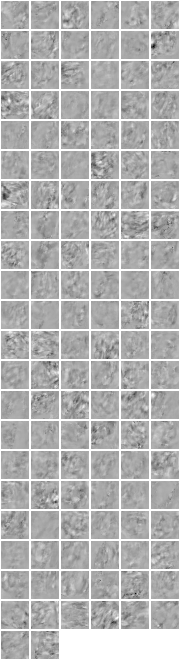

In [106]:
w = net:get(5).weight:reshape(10,128,28,28)
itorch.image(w[9])

### Debug the gradient

Compute the derivative numerically and compare

In [43]:
lena = image.lena():mean(1):squeeze()

local nWindows = 1
-- local nHaar = 5

net = Integral(nWindows, 512, 512)
-- net:add(nn.SpatialConvolutionMM(nWindows, nHaar, 1, 1, 1, 1))
-- net:add(nn.Tanh())
-- net:add(nn.Reshape(nHaar*512*512))
-- net:add(nn.Linear(nWindows*512*512, 10))

crit = nn.MSECriterion()

local int = net
int.xMin[1], int.yMin[1] = -10, 30
int.xMax[1], int.yMax[1] =  30, 300
-- int.xMin[2], int.yMin[2] = - 5, - 5
-- int.xMax[2], int.yMax[2] =  40,  40
int:recalculateArea()

param = {}
loss = {}
dL_dParam_nn = {}
dL_dParam_diff = {}

for i = 1,600 do
    param[i] = int.yMin[1] + i -- ***************************
    loss[i] = -666
    dL_dParam_nn[i] = -666
    dL_dParam_diff[i] = -666
end

cv.destroyAllWindows{}
cv.namedWindow{'w'}

for i = 1,#param do
    net:zeroGradParameters()
    int.yMax[1] = param[i] -- ***************************
    int:recalculateArea()
    
    pred = net:forward(lena)
    currLoss = crit:forward(pred, lena)
    dLoss_dOutput = crit:backward(pred, lena)
    net:backward(lena, dLoss_dOutput)
    
--     if param[i] > -10 and param[i] < 10 then
--         print(param[i])
--         cv.imshow{'w', pred:squeeze()}
--         cv.waitKey{0}
--     end
    
    loss[i] = currLoss
    dL_dParam_nn[i] = int.gradYMax[1] -- ***************************
    collectgarbage()
end

cv.destroyWindow{'w'}

for i = 1,#param-1 do
    dL_dParam_diff[i] = loss[i+1] - loss[i]
end

param[#param] = nil
dL_dParam_nn[#dL_dParam_nn] = nil
dL_dParam_diff[#dL_dParam_diff] = nil
loss[#loss] = nil

In [241]:
require 'gnuplot'

gnuplot.pngfigure('loss_yMin_rtz.png') -- ***************************
gnuplot.plot{
    {torch.Tensor(param), torch.Tensor(loss), '-'},
}
gnuplot.xlabel('parameter')
gnuplot.ylabel('Loss')
gnuplot.plotflush()

In [45]:
require 'gnuplot'

-- gnuplot.pngfigure('dLoss_dYMin_blur.png') -- ***************************
gnuplot.figure()
gnuplot.plot{
    {'manual', torch.Tensor(param), torch.Tensor(dL_dParam_nn), '-'},
    {'diff'  , torch.Tensor(param), torch.Tensor(dL_dParam_diff), '-'},
    {'zero'  , torch.Tensor{0, 0}, torch.Tensor{torch.Tensor(dL_dParam_diff):min(), torch.Tensor(dL_dParam_diff):max()}, '-'},
}
gnuplot.movelegend('right', 'middle')
gnuplot.xlabel('parameter')
gnuplot.ylabel('dLoss / dParameter')
-- gnuplot.plotflush()

Another method

In [869]:
source = image.lena():mean(1):squeeze()
source = image.convolve(source, image.gaussian(330), 'same')
source:add(-source:mean())
source:div(source:std())

local int = nn.Integral(2, 512, 512)
int.xMin[1], int.yMin[1] = -140, -140
int.xMax[1], int.yMax[1] =  -20, - 20
int.xMin[2], int.yMin[2] = - 50, - 50
int.xMax[2], int.yMax[2] =  140,  140
int:recalculateArea()
filtered = int:forward(source)

target = filtered[1] - filtered[2]

In [870]:
simNet = nn.Sequential()
simNet:add(nn.Integral(2, 512, 512))
simNet:add(nn.SpatialConvolutionMM(2,1,1,1,1,1))

params, gradParams = simNet:getParameters()

crit = nn.MSECriterion()

-- local int = simNet:get(1)
-- int.xMin[1], int.yMin[1] = -10, -10
-- int.xMax[1], int.yMax[1] =   5,   5
-- int.xMin[2], int.yMin[2] = - 5, - 5
-- int.xMax[2], int.yMax[2] =  10,  10
-- int:recalculateArea()

-- simNet:get(2).weight[{1,1}] =  1
-- simNet:get(2).weight[{1,2}] = -1
-- simNet:get(2).bias[1] = 0

In [871]:
simDebugger = WindowDebugger()
xMin = {{}, {}}
xMax = {{}, {}}
convWeight = {{}, {}}
lossHist = {}

gradParams:zero()

In [885]:
optimState = {
    learningRate = 500e-3,
--     momentum = 0.9,
--     nesterov = true,
--     dampening = 0
}

function feval(params)
    gradParams:zero()

    local outputs = simNet:forward(source)
    local loss = crit:forward(outputs, target)
    local dLoss_dOutputs = crit:backward(outputs, target)
    simNet:backward(source, dLoss_dOutputs)

    return loss, gradParams
end

In [926]:
optimState.learningRate = 0.15

In [936]:
require 'optim'

local diff = false

function tocvimg(img)
    local retval = img:clone():squeeze()
    retval:div(retval:max())
    retval:add(-retval:min())
    return retval
end

for i = 1,100 do
    -- parameter history
    simDebugger:add(simNet:get(1))
    for j = 1,2 do
        xMin[j][#xMin[j]+1] = simNet:get(1).xMin[j]
        xMax[j][#xMax[j]+1] = simNet:get(1).xMax[j]
        convWeight[j][#convWeight[j]+1] = simNet:get(2).weight[{1,j}]
    end
    
    local _, loss = optim.adam(feval, params, optimState)
    lossHist[#lossHist+1] = loss
    
    if i % 10 == 0 then print(loss[1]) end
    if i % 10 == 0 then collectgarbage() end
end

1.1284322781746e-10	


2.3057028508688e-11	


2.2619688240522e-12	


3.1778585839193e-12	


1.5265132907727e-12	


7.2406116475784e-13	


1.4735726473671e-13	


2.4396232782423e-14	


3.7055760207256e-15	


7.0992177590647e-15	


In [964]:
simNet:get(2).weight, simNet:get(2).bias

-0.1494  0.4364
[torch.FloatTensor of size 1x2]

1e-08 *
-6.7629
[torch.FloatTensor of size 1]



5.9604644775391e-07	


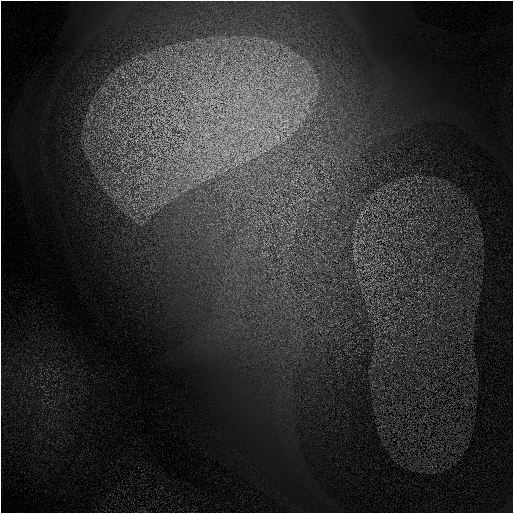

In [943]:
print(torch.abs(target-simNet:forward(source)):max())
itorch.image{torch.abs(target-simNet:forward(source))}
-- itorch.image{target, simNet:forward(source)}

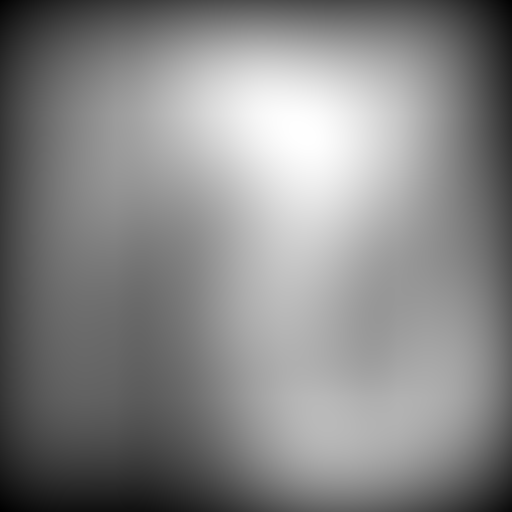

In [806]:
itorch.image(source)

In [938]:
gnuplot.pngfigure('loss_14-blur.png')
gnuplot.plot{
    {torch.Tensor(lossHist), '-'}
}
gnuplot.axis{0, #lossHist, -0, 9}
gnuplot.title('Recovering 1 Haar feature on 1 image using MSE (-0.1494 0.4364)')
gnuplot.xlabel('Iteration number')
gnuplot.ylabel('MSE')
gnuplot.plotflush()

In [939]:
gnuplot.figure()
gnuplot.plot{{torch.Tensor(xMin[1]), '-'}, {torch.Tensor(xMax[1]), '-'}}

In [940]:
simDebugger:exportVideo('similarity.avi', {{-140, -140, -20, -20}, {-50, -50, 140, 140}})

### Measure `Integral`'s efficiency

In [32]:
local nPlanes = 512
local convSize = 13

collectgarbage()

timer = torch.Timer()
res = nn.Integral(nPlanes, 512, 512):forward(image.lena():mean(1):squeeze())
boxTime = timer:time().real
print('Time elapsed for '..nPlanes..' box filters: ' ..boxTime.. ' seconds')

collectgarbage()

convTimes = {}
torch.setnumthreads(1)

for convSize = 1,35,2 do
    timer = torch.Timer()
    res = nn.SpatialConvolutionMM(1, nPlanes, convSize, convSize):forward(image.lena():mean(1))
    convTimes[#convTimes+1] = timer:time().real
    -- print('Time elapsed for '..nPlanes..' '..convSize..'x'..convSize..' convolutions: ' ..convTimes[i].. ' seconds')
end

Time elapsed for 512 box filters: 1.261351108551 seconds	


In [48]:
require 'gnuplot'

gnuplot.pngfigure('times.png')
gnuplot.plot{
    {'Box filter', torch.Tensor{1,35}, torch.Tensor{boxTime, boxTime}},
    {'General convolution', torch.range(1,35,2), torch.Tensor(convTimes)}
}
gnuplot.movelegend('left', 'top')
gnuplot.title('Convolving a 512x512 image 512 times')
gnuplot.xlabel('Kernel size')
gnuplot.ylabel('Time, seconds')
gnuplot.plotflush()

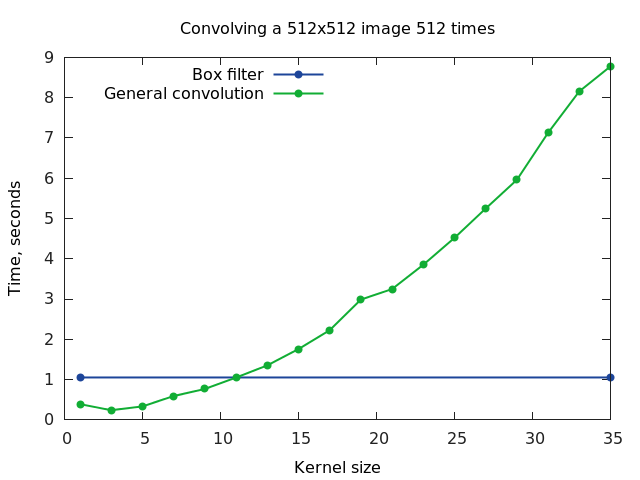

In [49]:
itorch.image('times.png')